# Statistical Machine Learning Exercise Sheet 7
- Laura Haege
- Philipp Noel von Bachmann, Matrikelnummer: 4116220

## Exercise 11

### (a)
\begin{align*}
  \langle \Phi_m(x), \Phi_m(y) \rangle
  &= \sum_{m \in M} \Phi_m(x), \Phi_m(y)\\
  &= \sum_{m \in M} \sqrt{\frac{d!}{\prod_i m_i!}} \prod_i x_i^{m_i} \cdot \sqrt{\frac{d!}{\prod_i m_i!}} \prod_i y_i^{m_i}\\
  &= \sum_{m \in M} \frac{d!}{\prod_i m_i!} (\prod_i x_i^{m_i}  \prod_i y_i^{m_i})\\
  &= \sum_{m \in M} \frac{d!}{\prod_i m_i!} \prod_i x_i^{m_i}y_i^{m_i}\\
  &= \sum_{m \in M} \frac{d!}{\prod_i m_i!} \prod_i (x_i \cdot y_i)^{m_i}\\
  &= (x_1 \cdot y_1 + \dots + x_n \cdot y_n)^d\\
  &= \langle x, y\rangle^d
\end{align*}

### (b)

assume a Loss function $\sum\limits_{i=1}^{n} L(y_i, \phi (x_i)) + \lambda \vert \vert \phi \vert \vert_ {H}^2$ minimized by $\phi^*(x) = \sum\limits_{i=1}^{n} \alpha_i K(x,x_i) \\ $ equivalent (due to representer theorem) to: $\sum\limits_{i=1}^{n} L(y_i, \alpha_i K) + \lambda \sum\limits_{j,i=1}^{n} \alpha_i \alpha_j K \\ $ for $L_2$ - Loss there exists a unique solution: $ \alpha^* = (K + \lambda I)^{-^1} y  $ With $ \\ \Omega = R^d$ we get $K(x,y) = (1 + \sum\limits_{i=1}^{n} x_i y_i) ^d = (1 + \sum\limits_{i=0}^{n-1} x_i y_i)^d \\ 
= {d \choose k} 1^{d-k} * \sum\limits_{i=0}^{n-1} x_i y_i^d $

Therefore the dimension of $H$ is $  (d + n-1) \choose d $

### (c)

We have $d=5$ and $n = 16 * 16 = 256$. Therefore we get a dimension of $H$ of
 ${5 + 256 + 1\choose 5} = {262 \choose 5}$. This means we have too mayn features to explicitly compute/store. However if we use the kernel $\langle x,y \rangle^5$, we first have to take a product over 256 dimensions and then a sum over 256 dimensions and finally just compute the power of one number, which is much cheaper to compute and store. 

## Exercise 12

We can reformulate the problem as:
\begin{align*}
  R(f') 
  &= \inf_{f \in F} R(f) +  R(f') - \inf_{f \in F} R(f)\\
  &\leq \inf_{f \in F} R(f) +  \vert R(f') - \inf_{f \in F} R(f) \vert \\
  &\leq \inf_{f \in F} R(f) + 2 \sup_{f \in F} \vert \hat{R}_m(f) - R(f)\vert \\
\end{align*}

Therefore it is sufficient to show that $P(2 \sup_{f \in F} \vert \hat{R}_m(f) - R(f)\vert \geq \epsilon ) \leq \delta \Rightarrow \epsilon = \sqrt{\frac{2}{m}\log{\frac{2N}{\delta}}}$

Reformulating gives
\begin{align*}
  P(2 \sup_{f \in F} \vert \hat{R}_m(f) - R(f)\vert \geq \epsilon )
  & = P(\sup_{f \in F} \vert \hat{R}_m(f) - R(f)\vert \geq \frac{\epsilon}{2} )\\
  & \leq P( \cup_{f \in F}  (\lvert \hat{R}_m(f)-R(f) \rvert \geq \frac{\epsilon}{2})\\
  & = \sum_{f \in F} P(\lvert \hat{R}_m(f)-R(f) \rvert \geq \frac{\epsilon}{2})\\
  & = \sum_{f \in F} 2 exp(- 2 m (\frac{\epsilon}{2})^2)\\
  & = 2 N exp(- \frac{1}{2} m \epsilon^2)\\
  & \Rightarrow \delta = 2 N exp(- \frac{1}{2} m \epsilon^2)
\end{align*}


Now solve for epsilon

\begin{align*}
  \delta & = 2 N \exp(- \frac{1}{2} m \epsilon^2)\\
  \frac{\delta}{2N} & = \exp(- \frac{1}{2} m \epsilon^2)\\
  \frac{2N}{\delta}& = \exp( \frac{1}{2} m \epsilon^2)\\
  \log{\frac{2N}{\delta}}& = \frac{1}{2} m \epsilon^2\\
  \frac{2}{m}\log{\frac{2N}{\delta}}& =  \epsilon^2\\
  \sqrt{\frac{2}{m}\log{\frac{2N}{\delta}}}& =  \epsilon\\
\end{align*}



## Exercise 13

In [1]:
import numpy as np
from numpy.linalg import norm
from scipy.linalg import cho_factor, cho_solve
from scipy.spatial.distance import cdist

In [2]:
data = np.load("diabetes_data.npy", allow_pickle=True).item()
X_train = data["Xtrain"]
Y_train = data["Ytrain"]
X_test = data["Xtest"]
Y_test = data["Ytest"]

In [3]:
def gaussian_kernel(x, y, mu):
    return np.exp(- mu * cdist(x,y)**2) 
    
def Loss(Y, Y_prediction):
    return 0.5* norm(Y == np.sign(Y_prediction))

In [4]:
def train(X, Y, lambda_reg, mu):
    n = X.shape[0]
    K = gaussian_kernel(X, X, mu)
    alpha = cho_solve(cho_factor(K + n * lambda_reg * np.eye(n)), Y)
    train_loss = Loss(Y, predict(X, X, alpha, mu))
    return alpha, train_loss

def predict(X_pred, X_t, alpha, mu):
    return np.sum(np.multiply(np.squeeze(alpha), gaussian_kernel(X_pred, X_t, mu)), axis=1)
    
def test(X_test, Y_test, X, alpha, mu):
    return Loss(Y_test, predict(X_test, X, alpha, mu))

In [5]:
def CrossValidation(X, Y, lambdas, mus, k=5):
    X_split = np.array(np.array_split(X, k))
    Y_split = np.array(np.array_split(Y, k))
    min_loss=np.inf
    min_mu = None 
    min_lambda = None
    CVErrors = np.zeros((len(lambdas), len(mus)))

    for mu_index, mu in enumerate(mus):
        for l_index, l in enumerate(lambdas):
            # compute k-fold cross validation
            validation_loss = []
            for i in range(k):
                x_train = np.concatenate(np.delete(X_split, i, axis=0))
                y_train = np.concatenate(np.delete(Y_split, i, axis=0))
                x_val = X_split[i]
                y_val = Y_split[i]
                alphas, train_loss = train(x_train, y_train, l, mu)
                validation_loss.append(test(x_val, y_val, x_train, alphas, mu)) 
            # average over all losses and store
            validation_loss = np.mean(validation_loss)
            CVErrors[l_index, mu_index] = validation_loss
            # check if smaller
            if validation_loss < min_loss:
                min_loss = validation_loss
                min_mu = mu
                min_lambda = l
    print(f"The pest parameters are given as mu={min_mu}, lambda={min_lambda}")
    # finally train on the whole set again
    return train(X, Y, min_lambda, min_mu), CVErrors


Cross Validation Training

In [6]:
mus = [1e-4, 1e-3, 1e-2, 1e-1, 1]
lambdas = [1e-4, 1e-3, 1e-2, 1e-1, 1]
(best_alphas, final_train_loss), validation_loss = CrossValidation(X_train, Y_train, lambdas, mus, 5)
print("The resulting train loss is: ", final_train_loss)

The pest parameters are given as mu=0.1, lambda=0.0001
The resulting train loss is:  95.33362470817943


Evaluating of the final parameters on the test set

In [7]:
test_loss = test(X_test, Y_test, X_train, alpha=best_alphas, mu=0.1)
print("The resulting test loss is: ", test_loss)

The resulting test loss is:  193.4644670217247


### Plots

In [8]:
def train_test_plot(x_train, y_train, x_test, y_test, lambdas, mus):
    TrainErrors = np.zeros((len(lambdas), len(mus)))
    TestErrors = np.zeros((len(lambdas), len(mus)))
    for mu_index, mu in enumerate(mus):
        for l_index, l in enumerate(lambdas):
            # compute k-fold cross validation
            alphas, train_loss = train(x_train, y_train, l, mu)
            TrainErrors[l_index, mu_index] = train_loss
            TestErrors[l_index, mu_index] = test(x_test, y_test, x_train, alpha=alphas, mu=mu)
    return TrainErrors, TestErrors

In [9]:
TrainErrors, TestErrors = train_test_plot(X_train, Y_train, X_test, Y_test, lambdas, mus)

In [10]:
plot_lambda, plot_mu = np.meshgrid(np.log10(lambdas), np.log10(mus))


For cross validation

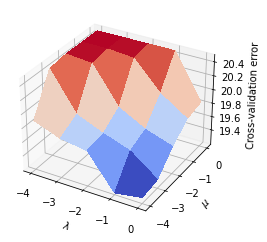

In [11]:
from matplotlib import pyplot as plt
from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(plot_lambda, plot_mu, validation_loss, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set(xlabel="$\lambda$", ylabel="$\mu$", zlabel="Cross-validation error");

For whole train set

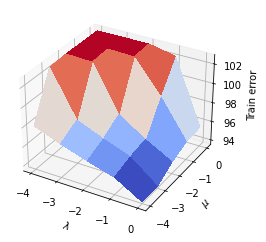

In [12]:
from matplotlib import pyplot as plt
from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(plot_lambda, plot_mu, TrainErrors, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set(xlabel="$\lambda$", ylabel="$\mu$", zlabel="Train error");

For test set

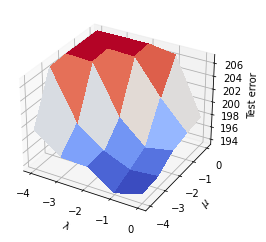

In [13]:
from matplotlib import pyplot as plt
from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(plot_lambda, plot_mu, TestErrors, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set(xlabel="$\lambda$", ylabel="$\mu$", zlabel="Test error");

We can see in general that the larger $\mu$ gets, the better the error becomes. For $\lambda$ it is the other way around. Note however that the minimum for the Test error and the Cross Validation error is not given for $\mu = 1$ (as in the Train set), but for $\mu =0.1$. This shows that Cross validation gives a better estimate of the test error.